# EDA on the historical flights dataset

### Imports

In [118]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Reading data

In [119]:
df = pd.read_csv("../data/historical_flights.csv")
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 410442 entries, 0 to 410441
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   flight_id          410442 non-null  object
 1   dep_airport        410442 non-null  object
 2   dep_airport_group  232968 non-null  object
 3   arr_airport        410442 non-null  object
 4   arr_airport_group  231669 non-null  object
 5   service_type       410336 non-null  object
 6   std                410442 non-null  object
 7   sta                410442 non-null  object
 8   cancelled          410442 non-null  int64 
 9   atd                394327 non-null  object
 10  ata                393576 non-null  object
dtypes: int64(1), object(10)
memory usage: 34.4+ MB
None


In [120]:
# Checking its shape for choosing future cross validation
print(df.shape)

(410442, 11)


we still do not know the size of our training dataset, but this will still valuable info

### Checking for missing data

In [121]:
print(df.isnull().sum().sum())

389334


In [122]:
print(df.isnull().sum())

flight_id                 0
dep_airport               0
dep_airport_group    177474
arr_airport               0
arr_airport_group    178773
service_type            106
std                       0
sta                       0
cancelled                 0
atd                   16115
ata                   16866
dtype: int64


In [123]:
print(df["dep_airport_group"])

0           B
1         NaN
2           A
3           B
4           B
         ... 
410437      A
410438    NaN
410439    NaN
410440      D
410441      A
Name: dep_airport_group, Length: 410442, dtype: object


The NaN in dep_airport_group and arr_airport_group means the flight is not departuring or arriving in one of Avinors airport group, but from another airport. Missing values from atd and ata is ok, because it means the flight depatures and arrivals did not get changed.

In [124]:
# service_type, dep_airport and arr_airport is not relevant. That is because service type does not explain simultaneity
# and we do not need the airport symbol, therefore we can remove those features.
df_reduced = df.drop(columns = ["service_type", "dep_airport", "arr_airport"])
print(df_reduced)

       flight_id dep_airport_group arr_airport_group  \
0          WF149                 B               NaN   
1          WF722               NaN                 D   
2          WF188                 A               NaN   
3          WF176                 B               NaN   
4          WF148                 B               NaN   
...          ...               ...               ...   
410437     WF153                 A                 B   
410438     WF153               NaN                 A   
410439     WF158               NaN                 B   
410440     WF721                 D               NaN   
410441     WF182                 A               NaN   

                               std                         sta  cancelled  \
0       2018-01-02T16:40:00.000000  2018-01-02T17:15:00.000000          0   
1       2018-01-28T13:04:00.000000  2018-01-28T14:50:00.000000          0   
2       2018-04-07T07:10:00.000000  2018-04-07T08:10:00.000000          0   
3       2018-04-07T

In [125]:
# It would be great to also remove cancelled flights to reduce noise.
df_cleaned = df_reduced[df_reduced["cancelled"] != 1].copy()
df_cleaned = df_cleaned.drop(columns = "cancelled")
print(df_cleaned.shape)  # Checking how much was removed.

(399426, 7)


We still have alot data to work with

### Testing feature enineering

In [ ]:
# Departures dataframe
df_departures = df_cleaned[["dep_airport_group", "std", "atd"]].copy()
df_departures = df_departures.rename(columns = {
    "std": "datetime",
    "atd": "actual_datetime",
    "dep_airport_group": "airport_group"
})

# Arrivals dataframe
df_arrivals = df_cleaned[["arr_airport_group", "sta", "ata"]].copy()
df_arrivals = df_arrivals.rename(columns = {
    "sta": "datetime",
    "ata": "actual_datetime",
    "arr_airport_group": "airport_group"
})

# Combine if needed
df_events = pd.concat([df_departures, df_arrivals], ignore_index = True)

df_events 

,airport_group,datetime,actual_datetime
0,B,2018-01-02T16:40:00.000000,NaN
1,NaN,2018-01-28T13:04:00.000000,NaN
2,A,2018-04-07T07:10:00.000000,NaN
3,B,2018-04-07T11:00:00.000000,NaN
4,B,2018-04-30T08:25:00.000000,NaN
...,...,...,...
798847,B,2025-05-03T10:00:00.000000,2025-05-03T10:19:00.000000
798848,A,2025-05-03T09:10:00.000000,2025-05-03T09:18:00.000000
798849,B,2025-05-03T15:50:00.000000,2025-05-03T15:39:00.000000
798850,NaN,2025-05-03T09:45:00.000000,2025-05-03T09:39:00.000000


In [127]:
# Ensure datetime columns are proper datetimes
df_events["datetime"] = pd.to_datetime(df_events["datetime"], errors = "coerce")
df_events["actual_datetime"] = pd.to_datetime(df_events["actual_datetime"], errors = "coerce")


df_events["sched_date"] = df_events["datetime"].dt.date
df_events["sched_hour"] = df_events["datetime"].dt.hour

df_events["actual_date"] = df_events["actual_datetime"].dt.date
df_events["actual_hour"] = df_events["actual_datetime"].dt.hour

# Helper function to calculate concurrency
def compute_concurrency(times):
    times = times.dropna().sort_values()
    count = 0
    for i, t1 in enumerate(times):
        for j, t2 in enumerate(times):
            if i >= j:  # avoid double counting and self
                continue
            delta = (t2 - t1).total_seconds() / 60.0  # minutes difference
            if -16 <= delta <= 5:
                count += 1
    return count

# Group by scheduled info first (keeping actual separate)
df_grouped = (
    df_events.groupby(["sched_date", "sched_hour", "airport_group"])
    .apply(lambda g: pd.Series({
        "sched_flights": len(g),
        "sched_concurrence": compute_concurrency(g["datetime"]),
        "actual_concurrence": compute_concurrency(g["actual_datetime"])
    }))
    .reset_index()
    .rename(columns = {"sched_date": "date", "sched_hour": "hour"})
    .sort_values(by = ["date", "hour", "airport_group"])
)

df_grouped


C:\Users\milad\AppData\Local\Temp\ipykernel_26672\1431137086.py:28: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


,date,hour,airport_group,sched_flights,sched_concurrence,actual_concurrence
0,2018-01-01,7,C,1,0,0
1,2018-01-01,8,C,3,0,0
2,2018-01-01,9,C,1,0,0
3,2018-01-01,9,D,1,0,0
4,2018-01-01,10,C,1,0,0
...,...,...,...,...,...,...
191426,2025-07-31,21,C,1,0,0
191427,2025-07-31,21,D,3,0,1
191428,2025-07-31,21,E,2,0,0
191429,2025-07-31,21,G,2,0,0


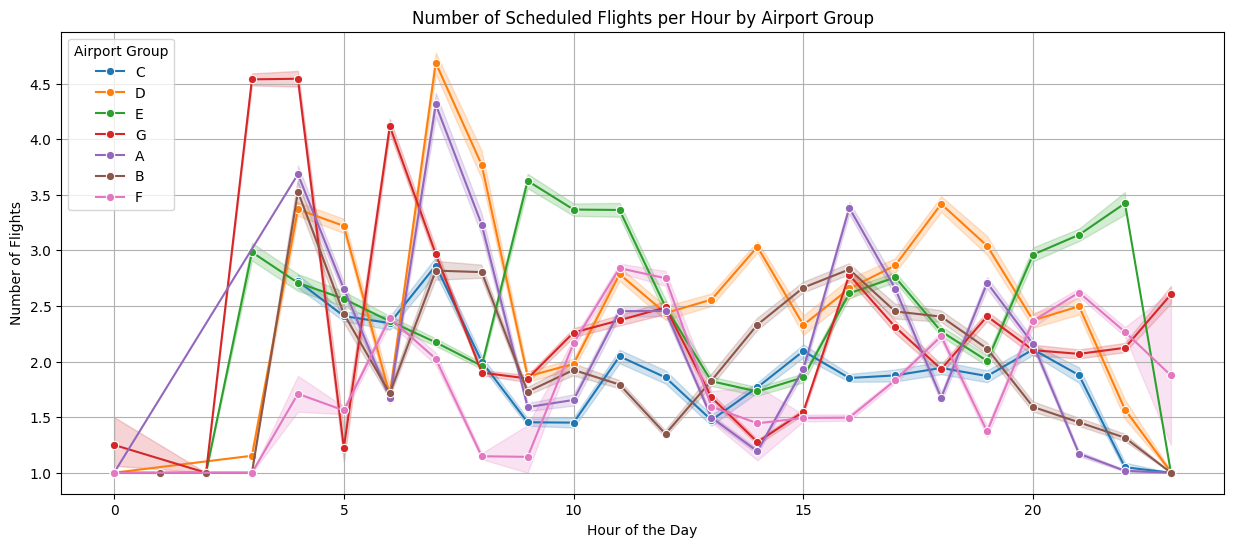

In [128]:
plt.figure(figsize = (15,6))
sns.lineplot(
    data=df_grouped,
    x = 'hour',
    y = 'sched_flights',
    hue = 'airport_group',
    marker = 'o'
)
plt.title('Number of Scheduled Flights per Hour by Airport Group')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Flights')
plt.legend(title = 'Airport Group')
plt.grid(True)
plt.show()


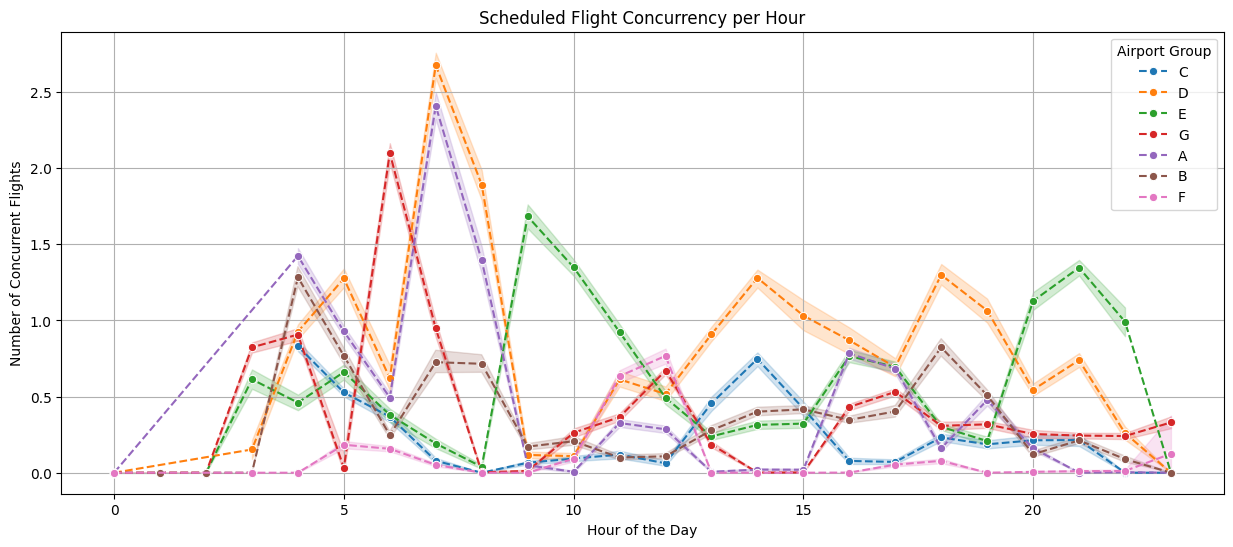

In [129]:
plt.figure(figsize = (15,6))
sns.lineplot(
    data = df_grouped,
    x = 'hour',
    y = 'sched_concurrence',
    hue = 'airport_group',
    marker = 'o',
    linestyle = '--'
)
plt.title('Scheduled Flight Concurrency per Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Concurrent Flights')
plt.grid(True)
plt.legend(title='Airport Group')
plt.show()

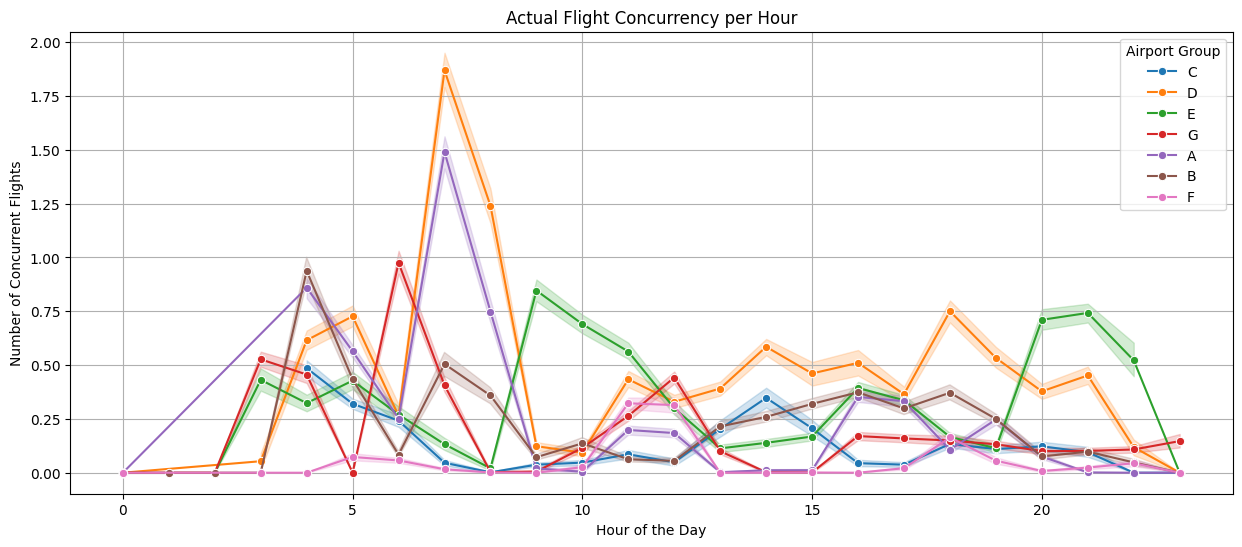

In [130]:
plt.figure(figsize = (15,6))
sns.lineplot(
    data = df_grouped,
    x = 'hour',
    y = 'actual_concurrence',
    hue = 'airport_group',
    marker = 'o'
)
plt.title('Actual Flight Concurrency per Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Concurrent Flights')
plt.grid(True)
plt.legend(title = 'Airport Group')
plt.show()

In [131]:
# if there is any actual concurrency, else 0
df_grouped["concurrency"] = (df_grouped["actual_concurrence"] > 0).astype(int)

# Probability of concurrency per airport group per hour
df_grouped["pct_concurrency"] = (df_grouped.groupby(["airport_group", "hour"])["concurrency"].transform("mean"))

df_grouped

,date,hour,airport_group,sched_flights,sched_concurrence,actual_concurrence,concurrency,pct_concurrency
0,2018-01-01,7,C,1,0,0,0,0.046138
1,2018-01-01,8,C,3,0,0,0,0.001905
2,2018-01-01,9,C,1,0,0,0,0.036718
3,2018-01-01,9,D,1,0,0,0,0.111541
4,2018-01-01,10,C,1,0,0,0,0.046921
...,...,...,...,...,...,...,...,...
191426,2025-07-31,21,C,1,0,0,0,0.075840
191427,2025-07-31,21,D,3,0,1,1,0.352737
191428,2025-07-31,21,E,2,0,0,0,0.532468
191429,2025-07-31,21,G,2,0,0,0,0.096600


In [132]:
# Getting the season.
def get_season(date):
    month = date.month
    day = date.day
    if (month == 12 and day >= 21) or (month <= 3 and (month != 3 or day <= 19)):
        return 'Winter'
    elif (month == 3 and day >= 20) or (month in [4, 5]) or (month == 6 and day <= 20):
        return 'Spring'
    elif (month == 6 and day >= 21) or (month in [7, 8]) or (month == 9 and day <= 21):
        return 'Summer'
    else:
        return 'Fall'

# Create season column
df_grouped['season'] = df_grouped['date'].apply(get_season)

# Reordering
cols = df_grouped.columns.tolist()
cols.insert(cols.index('hour') + 1, cols.pop(cols.index('season')))
df_grouped = df_grouped[cols]

final_df = df_grouped.copy()
final_df

,date,hour,season,airport_group,sched_flights,sched_concurrence,actual_concurrence,concurrency,pct_concurrency
0,2018-01-01,7,Winter,C,1,0,0,0,0.046138
1,2018-01-01,8,Winter,C,3,0,0,0,0.001905
2,2018-01-01,9,Winter,C,1,0,0,0,0.036718
3,2018-01-01,9,Winter,D,1,0,0,0,0.111541
4,2018-01-01,10,Winter,C,1,0,0,0,0.046921
...,...,...,...,...,...,...,...,...,...
191426,2025-07-31,21,Summer,C,1,0,0,0,0.075840
191427,2025-07-31,21,Summer,D,3,0,1,1,0.352737
191428,2025-07-31,21,Summer,E,2,0,0,0,0.532468
191429,2025-07-31,21,Summer,G,2,0,0,0,0.096600


All feature egineering will be implementet to data.py from this file.  
The target will be concurrence, however when we predict future data we do not know the actual_concurrence. So we will not involve this feature